# Massive Data Analysis 2021
# Project
# Mohammadreza Taremi -- 96101902


-----------------------------------------------------------------

## Setup
--------------------------------------------------

Let's setup Spark on our Colab environment:

In [1]:
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

     |████████████████████████████████| 281.4 MB 36 kB/s 
     |████████████████████████████████| 198 kB 40.2 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=421a1978e4393b2a6ef254042a682233c14215abb3a6ed0b6237bfc9270c0bf2
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark
The following packages were automatically installed and are no longer required:
  cuda-command-line-tools-10-0 cuda-command-line-tools-10-1
  cuda-command-line-tools-11-0 cuda-compiler-10-0 cuda-compiler-10-1
  cuda-compiler-11-0 cuda-cuobjdump-10-0 cuda-cuobjdump-10-1
  cuda-cuobjdump-11-0 cuda-cupti-10-0 cuda-cupti-10-1 cuda-cupti-11-0
  cuda-cupti-dev-11-0 cuda-documentation-10-0 cuda-documentation-10-1
  cuda-documentation-11-0 cuda-documentation-11-1 cuda-gdb-10-0 cuda-gdb-10-1
  cuda-gdb-11-0 cuda-gpu-library-advisor-10-0 cuda-gpu-library-advisor-10-1
  cuda-libraries-10-0 cuda

Now we authenticate a Google Drive client to processing data



In [2]:
from google.colab import drive
# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


## Check and extract data
--------------------------------------------------

In [ ]:
!ls '/content/drive/My Drive/Sample_Data.zip'

ls: cannot access '/content/drive/My Drive/Sample_Data.zip': No such file or directory


In [ ]:
!unzip "/content/drive/My Drive/Sample_Data.zip" -d "/content/drive/My Drive/Sampe_Data"

Archive:  /content/drive/My Drive/Sample_Data.zip
replace /content/drive/My Drive/Sampe_Data/Sample_Traffic.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


the cells above, extract data which is in '/content/drive/My Drive/Sample_Data.zip' 


## Initializing Spark and read data
--------------------------------------------------

In [3]:
from pyspark import SparkContext, SparkConf 
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType,StructField, StringType, IntegerType,TimestampType
from pyspark.sql.functions import col,current_timestamp,to_date,hour,dayofweek
spark = SparkSession \
    .builder \
    .appName("Spark_Processor") \
    .master("local[*]") \
    .getOrCreate()

sc=spark.sparkContext

schema = StructType([ \
        StructField("DEVICE_CODE", IntegerType(), True), 
        StructField("SYSTEM_ID",IntegerType(),True), \
        StructField("ORIGINE_CAR_KEY",StringType(),True), \
        StructField("FINAL_CAR_KEY",StringType(),True), \
        StructField("CHECK_STATUS_KEY", IntegerType(), True), \
        StructField("COMPANY_ID", StringType(), True), \
        StructField("PASS_DAY_TIME", TimestampType(), True)
    ])

In [4]:
df=spark.read.csv('/content/drive/My Drive/Sampe_Data/Sample_Traffic.csv',header=True,schema=schema)

In [5]:
df.head()

Row(DEVICE_CODE=200501, SYSTEM_ID=81, ORIGINE_CAR_KEY='10477885', FINAL_CAR_KEY='10477885', CHECK_STATUS_KEY=5, COMPANY_ID='161', PASS_DAY_TIME=datetime.datetime(2021, 6, 1, 3, 54, 39))

In [6]:
#Part 1
#In this part, we dump all the columns of dataframe except PASS_DAY_TIME, FINAL_CAR_KEY, and DEVICE_CODE
df = df[['DEVICE_CODE','FINAL_CAR_KEY','PASS_DAY_TIME']]

#sampling the dataset
# df = df.sample(withReplacement=False, fraction = 0.01, seed = 101)
df.show(1)

+-----------+-------------+-------------------+
|DEVICE_CODE|FINAL_CAR_KEY|      PASS_DAY_TIME|
+-----------+-------------+-------------------+
|     200501|     10477885|2021-06-01 03:54:39|
+-----------+-------------+-------------------+
only showing top 1 row



In [7]:
"""
we need a secondary df in which the PASS_DAY_TIME column is only indicating 
the hour not the entire date time, therefore we need to extract hour from each
of the datetimes given in dataframe with dataframe.collect()[row_index][column_index]

df.collect()[0][0] returns 143

Day of week ranges from 1 to 7. (1- Sunday , 2- Monday …… 7- Saturday)

"""
df_1 = df.withColumn('DAY_OF_WEEK',dayofweek(df.PASS_DAY_TIME))
df_2 = df_1.withColumn('HOUR', hour(df_1.PASS_DAY_TIME))

In [ ]:
df_2.show(1)

+-----------+-------------+-------------------+-----------+----+
|DEVICE_CODE|FINAL_CAR_KEY|      PASS_DAY_TIME|DAY_OF_WEEK|HOUR|
+-----------+-------------+-------------------+-----------+----+
|     200501|     10477885|2021-06-01 03:54:39|          3|   3|
+-----------+-------------+-------------------+-----------+----+
only showing top 1 row



In [8]:
import numpy as np
#Defining a matrix with the size of 7*24
n_traverse = np.zeros(shape=(df_2.select(df_2.DEVICE_CODE).distinct().count(),7,24))

In [9]:
cameras = [x.DEVICE_CODE for x in df_2.select('DEVICE_CODE').distinct().collect()]

In [12]:
df_3 = df_2.groupby(['DEVICE_CODE','DAY_OF_WEEK','HOUR']).count()

In [ ]:
df_3.show(5)

+-----------+-----------+----+-----+
|DEVICE_CODE|DAY_OF_WEEK|HOUR|count|
+-----------+-----------+----+-----+
|     631763|          3|   1|   89|
|        125|          3|   0|    1|
|        169|          3|   6|  197|
|     631776|          3|   4|    7|
|     900222|          3|   0|  263|
+-----------+-----------+----+-----+
only showing top 5 rows



In [ ]:
#for intution
df_2.filter(df_2.DEVICE_CODE == 900182).show()

+-----------+-------------+-------------------+-----------+----+
|DEVICE_CODE|FINAL_CAR_KEY|      PASS_DAY_TIME|DAY_OF_WEEK|HOUR|
+-----------+-------------+-------------------+-----------+----+
|     900182|      8303686|2021-06-01 06:29:00|          3|   6|
|     900182|     61055690|2021-06-01 05:51:11|          3|   5|
|     900182|     45906776|2021-06-01 06:24:42|          3|   6|
|     900182|     92134072|2021-06-01 06:22:06|          3|   6|
|     900182|     42950449|2021-06-01 06:13:03|          3|   6|
|     900182|     84806897|2021-06-01 06:21:24|          3|   6|
|     900182|     86925778|2021-06-01 05:50:25|          3|   5|
|     900182|     67375921|2021-06-01 05:16:57|          3|   5|
|     900182|     48498910|2021-06-01 05:16:10|          3|   5|
|     900182|     78240031|2021-06-01 04:56:27|          3|   4|
|     900182|     88105464|2021-06-01 05:04:36|          3|   5|
|     900182|      7938334|2021-06-01 06:28:09|          3|   6|
|     900182|     2208289

In [ ]:
#i used a dictionary to store the index of each camera for future analysis
cam_dict = {}
for i, camcode in enumerate(cameras):
  cam_dict[i] = camcode
cam_dict = {v: k for k, v in cam_dict.items()}
cam_dict

In [13]:
for cam,d,h,count in df_3.collect():
  n_traverse[cam_dict[cam],d-1,h-1] = count

In [14]:
n_traverse.shape

(993, 7, 24)

In [15]:
#Implementing Collaborative Filtering Method on n_traverse
#Memory Based Approach
import pandas as pd

user_item_mat = np.zeros(shape=(len(cameras),7*24))
for i in range(user_item_mat.shape[0]):
  user_item_mat[i] = n_traverse[i].ravel()

In [ ]:
user_item_df = pd.DataFrame(user_item_mat)
corr_df = user_item_df.T.corr()
corr_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711,712,713,714,715,716
0,1.000000,0.222621,0.276549,0.441643,0.123884,0.364643,0.169325,0.104620,0.267636,0.364265,0.315698,0.135311,0.279084,0.568579,0.296157,0.451183,0.180763,-0.014801,0.399616,-0.018182,-0.010434,0.325497,0.361097,-0.014801,0.307542,0.405496,-0.010434,-0.010434,0.238359,0.282414,0.409543,0.413312,0.304681,0.285652,0.302921,0.345418,0.151383,0.343717,0.416287,-0.010434,...,0.098794,-0.019953,0.220410,0.332159,0.151982,-0.010434,0.573883,0.660606,-0.010434,0.220813,-0.014801,-0.010434,-0.010434,-0.014033,-0.017125,-0.017125,-0.010434,-0.010434,-0.010434,0.066931,-0.010434,-0.018182,-0.010434,0.573883,0.310510,-0.010434,0.573883,0.170207,0.573883,-0.010434,-0.018182,-0.010434,-0.010434,0.573883,0.234974,0.171289,0.093385,-0.010434,0.170089,-0.010434
1,0.222621,1.000000,0.280842,0.221848,0.407088,0.035528,0.221846,0.443416,0.288646,0.291300,0.170985,0.201785,0.319511,-0.019834,0.434366,0.282890,0.478913,-0.013940,-0.013940,-0.017125,-0.009828,0.306572,0.184155,-0.013940,0.150510,0.356213,0.815688,-0.009828,0.268200,0.303801,0.219570,0.346851,0.178974,0.269043,0.122275,0.203179,0.233314,0.033490,0.254003,-0.009828,...,-0.018610,0.638974,0.207595,0.454418,0.213710,-0.009828,-0.009828,0.702112,-0.009828,0.103155,0.571543,-0.009828,-0.009828,0.171818,0.661290,0.322581,-0.009828,-0.009828,0.815688,0.111683,-0.009828,-0.017125,-0.009828,-0.009828,0.215926,-0.009828,-0.009828,0.062730,0.402930,-0.009828,-0.017125,-0.009828,-0.009828,0.402930,0.221313,0.361072,0.279779,-0.009828,0.043387,-0.009828
2,0.276549,0.280842,1.000000,0.784631,0.677693,0.845443,0.689903,0.535816,0.851348,0.910645,0.885976,0.542311,0.931284,0.388300,0.589571,0.863473,0.737168,0.310640,0.189906,0.276549,0.314753,0.959603,0.937541,0.084263,0.645120,0.670571,0.250916,0.314753,0.864818,0.840160,0.577682,0.797560,0.903987,0.881834,0.848024,0.891414,0.597565,0.788581,0.757074,0.165800,...,0.483780,0.391663,0.368010,0.550522,0.863624,0.314753,0.208358,0.276549,0.229637,0.844943,0.340824,0.123241,0.272195,0.184821,0.385611,0.472920,0.038125,0.123241,0.250916,0.791161,0.123241,0.424865,0.229637,0.208358,0.112198,0.123241,0.208358,0.679761,0.016846,0.229637,0.412506,0.123241,0.314753,0.016846,0.883870,0.820998,0.763817,0.123241,0.468517,0.272195
3,0.441643,0.221848,0.784631,1.000000,0.485929,0.756188,0.727829,0.492317,0.831720,0.886924,0.805175,0.345045,0.802504,0.741994,0.793218,0.795598,0.700537,0.209095,0.313230,0.242650,0.122938,0.831819,0.843111,0.313230,0.645169,0.449809,0.073996,0.122938,0.828306,0.765365,0.644549,0.719011,0.764676,0.802517,0.904554,0.790517,0.561752,0.728677,0.709939,0.122938,...,0.431400,0.484677,0.591886,0.523870,0.779276,0.122938,0.416592,0.327932,0.171881,0.756185,0.174384,0.465534,0.269765,0.560260,0.302172,0.201767,0.122938,0.465534,0.073996,0.657104,0.465534,0.271077,0.171881,0.416592,0.062063,0.465534,0.416592,0.745471,0.073996,0.171881,0.214222,0.025054,0.122938,0.073996,0.743576,0.727377,0.698786,0.465534,0.757840,0.269765
4,0.123884,0.407088,0.677693,0.485929,1.000000,0.599717,0.530667,0.738761,0.492796,0.677469,0.661235,0.392685,0.623224,0.232764,0.393319,0.660119,0.565713,0.163594,-0.024651,0.278051,-0.017379,0.735988,0.638628,-0.024651,0.333267,0.443953,0.513464,-0.017379,0.660715,0.628399,0.588623,0.665656,0.637932,0.640164,0.574424,0.499968,0.602209,0.554534,0.515766,0.248043,...,0.415853,0.305145,0.330697,0.513401,0.697819,-0.017379,-0.017379,0.278051,0.513464,0.687942,0.728332,-0.017379,0.248043,-0.023372,0.407088,0.189283,0.248043,-0.017379,0.513464,0.623135,-0.017379,-0.030283,0.513464,-0.017379,-0.024167,-0.017379,-0.017379,0.487422,-0.017379,0.513464,0.123884,-0.017379,-0.017379,-0.017379,0.709961,0.619242,0.688732,-0.017379,0.313338,0.248043
...,...,...,...,..

In [ ]:
corr_df = np.tril(corr_df,-1)

In [ ]:
pd.DataFrame(corr_df)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711,712,713,714,715,716
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1,0.222621,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2,0.276549,0.280842,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
3,0.441643,0.221848,0.784631,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
4,0.123884,0.407088,0.677693,0.485929,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

In [ ]:
idx = np.unravel_index(np.argsort(corr_df.ravel())[-100:], corr_df.shape)
idx

(array([662, 614, 424, 662, 614, 614, 714, 614, 614, 647, 672, 672, 672,
        672, 672, 672, 642, 673, 653, 653, 673, 714, 369, 369, 714, 423,
        642,  64,  64, 127, 403, 403, 675, 381, 675, 556, 328, 675, 675,
        674, 645, 710, 673, 673, 673, 676, 659, 653, 714, 662, 662, 535,
        714, 703, 535, 649, 535, 434, 703, 535, 703, 703, 703, 703, 703,
        535, 649, 535, 535, 658, 253, 662, 653, 693, 434, 328, 700, 716,
        647, 360, 693, 138, 360, 716, 360, 671, 671, 671, 671, 671, 658,
        616, 424, 617, 670, 670, 434, 670, 670, 649]),
 array([621, 288, 196, 628, 433, 437, 652, 580, 589, 626, 671, 667, 651,
        647, 636, 626, 378, 628, 616, 469, 654, 670, 141,  83, 668, 196,
        253,  20,  27,  93, 227, 163, 609, 210, 436, 143,  26, 127,  93,
        637, 205, 633, 662, 658, 653, 626, 625, 628, 638, 654, 658, 526,
        632, 700, 465, 220, 457, 284, 683, 408, 673, 662, 658, 654, 653,
        360, 203, 347, 295, 616,  20, 653, 621, 645, 175,  94, 469, 4

In [ ]:
idx_0 = idx[0].tolist()
idx_1 = idx[1].tolist()
camera_series = pd.Series(cameras)
accessed_series_0 = camera_series[idx_0].values
accessed_series_1 = camera_series[idx_1].values
sim_cameras = pd.DataFrame({'Camera 1': accessed_series_0, 'Camera 2': list(accessed_series_1)}, 
                           columns=['Camera 1', 'Camera 2'])

In [ ]:
sim_cameras

,Camera 1,Camera 2
0,900109,1001024
1,22009969,22009967
2,635616,631859
3,900109,100701268
4,22009969,631614
...,...,...
95,631937,631973
96,631980,631651
97,631937,100700920
98,631937,100700979


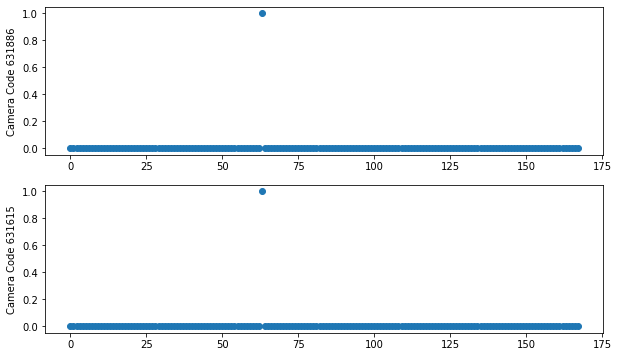

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, figsize=(10, 6))

ax[0].scatter(range(0,24*7),user_item_mat[cam_dict[631886]])
ax[0].set_ylabel('Camera Code 631886', labelpad = 5)

ax[1].scatter(range(0,24*7),user_item_mat[cam_dict[631615]])
ax[1].set_ylabel('Camera Code 631615', labelpad = 5)

plt.show()

In [ ]:
#Part 2
"""
In this part, firstly, we have to find all the unique paths.
Then, for every unique car, we find a sparse vector which contains 1s & 0s.
1 iff the path exists in the all_paths vector, and 0 if not.
By doing this, we can calculate the similarity among the cars.

"""
paths = cameras
cars =  [x.FINAL_CAR_KEY for x in df_2.select('FINAL_CAR_KEY').distinct().collect()]
adj_mat = np.zeros(shape=(len(cars),len(paths)))

In [ ]:
from pyspark.sql import functions as F
df_4 = df_2.groupBy('FINAL_CAR_KEY').agg(F.collect_list("DEVICE_CODE"))

In [ ]:
df_4.show(10)

+-------------+-------------------------+
|FINAL_CAR_KEY|collect_list(DEVICE_CODE)|
+-------------+-------------------------+
|    100001221|                 [631633]|
|    100002495|                 [200301]|
|     10000313|                 [900276]|
|     10000529|               [22010122]|
|     10000584|                 [900271]|
|     10001007|      [100700866, 900155]|
|     10001148|               [22010061]|
|     10001203|              [100700845]|
|     10001483|                 [900241]|
|    100015798|                 [212802]|
+-------------+-------------------------+
only showing top 10 rows



In [ ]:
#i used a dictionary to store the index of each camera for future analysis
car_dict = {}
for i, carcode in enumerate(cars):
  car_dict[i] = carcode
car_dict = {v: k for k, v in car_dict.items()}
car_dict

In [ ]:
for k,path in df_4.collect():
  for element in path:
    idx = paths.index(element)
    adj_mat[car_dict[k]][idx] = 1

In [ ]:
adj_mat

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
adj_mat[car_dict['10001007']][532]

1.0

In [ ]:
#Like the previous part, we calculate the correlation for each pair of rows
#in adj_mat which indicates cars(users in CF context)

import pandas as pd
threshold = 2
#To find the most travelled cars, i set a condition on the number of 1s
car_path_df = pd.DataFrame(adj_mat)
car_path_df = car_path_df[car_path_df.iloc[:, 1:].sum(axis=1)>=threshold]
corr_df_2 = car_path_df.T.corr()
corr_df_2 = np.tril(corr_df_2,-1)
idx_2 = np.unravel_index(np.argsort(corr_df_2.ravel())[-100:], corr_df_2.shape)
idx_0_2 = idx_2[0].tolist()
idx_1_2 = idx_2[1].tolist()
camera_series = pd.Series(cars)
accessed_series_0_2 = camera_series[idx_0_2].values
accessed_series_1_2 = camera_series[idx_1_2].values
sim_cars = pd.DataFrame({'Car 1': accessed_series_0_2, 'Car 2': list(accessed_series_1_2)}, 
                           columns=['Car 1', 'Car 2'])

In [ ]:
sim_cars

,Car 1,Car 2
0,72651996,10540364
1,8564333,7690476
2,10847623,20780484
3,8360156,88160685
4,16225843,9535614
...,...,...
95,8564333,101658815
96,82731815,61290290
97,7632487,68607132
98,9027836,8249581


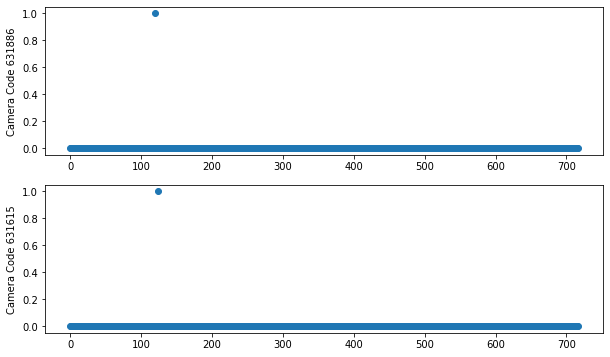

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, figsize=(10, 6))

ax[0].scatter(range(0,len(cameras)),adj_mat[car_dict['16225843']])
ax[0].set_ylabel('Camera Code 631886', labelpad = 5)

ax[1].scatter(range(0,len(cameras)),adj_mat[car_dict['9254994']])
ax[1].set_ylabel('Camera Code 631615', labelpad = 5)

plt.show()

In [ ]:
#PART 3
#normalizing the data
normalised_mat = car_path_df - np.asarray([(np.mean(car_path_df, 1))]).T

#utility matrix
A = normalised_mat.T / np.sqrt(car_path_df.shape[0] - 1)

from scipy.linalg import svd as scipy_svd
U, S, V = scipy_svd(A)

In [ ]:
pd.DataFrame(np.diag(S))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711,712,713,714,715,716
0,0.389204,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1,0.000000,0.212364,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2,0.000000,0.000000,0.188161,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
3,0.000000,0.000000,0.000000,0.178595,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
4,0.000000,0.000000,0.000000,0.000000,0.178459,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
712,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.683842e-18,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
713,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,6.050124e-18,0.000000e+00,0.000000e+00,0.000000e+00
714,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,5.662736e-18,0.000000e+00,0.000000e+00
715,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [ ]:
#Part 4-Clustering

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

feature_mat = user_item_mat
scaler = StandardScaler()
scaled_features = scaler.fit_transform(feature_mat)

kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}

# A list holds the SSE values for each k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_features)
    sse.append(kmeans.inertia_)

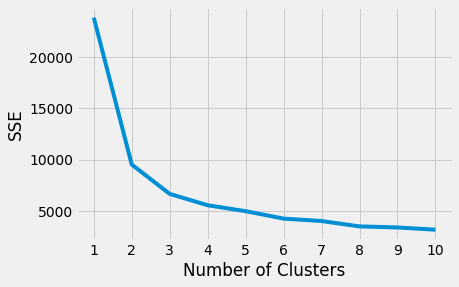

In [ ]:
 import matplotlib.pyplot as plt
 
 
 plt.style.use("fivethirtyeight")
 plt.plot(range(1, 11), sse)
 plt.xticks(range(1, 11))
 plt.xlabel("Number of Clusters")
 plt.ylabel("SSE")
 plt.show()

In [ ]:
labels = kmeans.labels_.tolist()
labels

In [ ]:
label0 = []
label1 = []
label2 = []
label3 = []
label4 = []
label5 = []
label6 = []
label7 = []
label8 = []
label9 = []

def get_key(val):
    for key, value in cam_dict.items():
         if val == value:
             return key
 
    return "key doesn't exist"

for i in range(len(labels)):
  if labels[i]==0:
    label0.append(get_key(i))

  if labels[i]==1:
    label1.append(get_key(i))

  if labels[i]==2:
    label2.append(get_key(i))

  if labels[i]==3:
    label3.append(get_key(i))

  if labels[i]==4:
    label4.append(get_key(i))

  if labels[i]==5:
    label5.append(get_key(i))

  if labels[i]==6:
    label6.append(get_key(i))

  if labels[i]==7:
    label7.append(get_key(i))

  if labels[i]==8:
    label8.append(get_key(i))

  if labels[i]==9:
    label9.append(get_key(i))

In [ ]:
pd.DataFrame(label1, columns=['1'])

In [16]:
#part 6-Hubs/Authorities
class Node:
    def __init__(self, name):
        self.name = name
        self.children = []
        self.parents = []
        self.auth = 1.0
        self.hub = 1.0
        self.pagerank = 1.0

    def link_child(self, new_child):
        for child in self.children:
            if(child.name == new_child.name):
                return None
        self.children.append(new_child)

    def link_parent(self, new_parent):
        for parent in self.parents:
            if(parent.name == new_parent.name):
                return None
        self.parents.append(new_parent)

    def update_auth(self):
        self.auth = sum(node.hub for node in self.parents)

    def update_hub(self):
        self.hub = sum(node.auth for node in self.children)

    def update_pagerank(self, d, n):
        in_neighbors = self.parents
        pagerank_sum = sum((node.pagerank / len(node.children)) for node in in_neighbors)
        random_jumping = d / n
        self.pagerank = random_jumping + (1-d) * pagerank_sum
  

In [17]:
def HITS_one_iter(graph):
    node_list = graph.nodes

    for node in node_list:
        node.update_auth()
    for node in node_list:
        node.update_hub()

    graph.normalize_auth_hub()

In [18]:
def update_auth(self):
    self.auth = sum(node.hub for node in self.parents)

def update_hub(self):
    self.hub = sum(node.auth for node in self.children)
    
def normalize_auth_hub(self):
    auth_sum = sum(node.auth for node in self.nodes)
    hub_sum = sum(node.hub for node in self.nodes)

    for node in self.nodes:
        node.auth /= auth_sum
        node.hub /= hub_sum